early version of model, with useful plots

# Modelling Notebook

this notebook uses beta(1+cs)  
the functions can be scaled differently depending on parameter values  
simulations and R0 plots can be made 
Hill function is included at the end  
shortened: Modelling Notebook scaled using beta(1+cs), simulations and R0 plots.ipynb is a more complete version if any older versions of functions are required


  $\frac{dS}{dt} = \nu  N - \frac{\beta_t  I  S} {N} - \mu S\\
  \frac{dE}{dt}=  \frac{\beta_t  I  S} {N} - (\sigma + \mu) E\\
  \frac{dI}{dt} = \sigma  E - (\alpha + \mu + \gamma) I\\
  \frac{dR}{dt} = \gamma I - \mu R $  
  
  
  $\beta_t = \beta_0  \ ( 1 + C(T) \times S(T) \times H )$  
  individuals/infected individual /unit time



  
  

  
   
   

$H=(1 - m\times \frac{I^3} {k^3 + I^3}) $
  
C and S are functions of climate (starting with temperature)
climate is a function of time 

T(t)
Humidity will also probably be included similarly to temperature 


## C -contact duration

$s=\frac{c_u-m_T}{1.96} \\
N_D(T)=  \frac{1}{\sqrt{2\pi}\times s} \times e^\frac{-(T-m_T)^2}{2 s^2}\\ $  
scaled to maximum duration:   
$C(T)= N_D(T) \times \sqrt{2\pi} \times s \times m_d$ units:time   
scaled to one:    
$C(T)= N_D(T) \times \sqrt{2\pi} \times s $ units:dimensionless  
s is from $CI=\mu \pm z s$, then rearrange.   
N_D is just the normal distribution.  
C(T) is the normal distribution scaled. This works because when $T=m_T$ then $N_D=\frac{1}{\sqrt{2\pi}s}$   


$m_T$ and $m_d$ are the temperature and duration of contact at the maximum duration. $c_l$ and $c_u$ is the interval at which 95\%  of the duration is likely to occur. The standard deviation $s$ is the calculated such that 95\% of the area falls between $c_l$ and $c_u$.  $N_D$ is the normal distribution with standard distribution $s$ and mean $m_T$. $T$ is the temperature.  

Initial ideas for estimating parameters:
 - use of polymod dataset
     - unfortunately in discrete categories so estimate midpoint of categories. For each participant, multiply number in each category by the midpoint and sum each compartment together. Then find the mean of this.
     - use the mean to predict the maximum (double??)
     - find minimum duration, and assign to lowest temperature 
     - n.b  in this dataset >24 hours is common because it is done by contacts.
     - considering limiting the type of interaction e.g. only physical or only leisure
 - another data source
     - google maps data (LOOK INTO WHAT IS AVAILABLE.https://ai.googleblog.com/2019/11/new-insights-into-human-mobility-with.html,https://www.google.com/covid19/mobility/,https://www.nature.com/articles/s41467-019-12809-y#MOESM1). intial thoughts is that it may be possible to find movement over time (weekly) but very complicated.  
     
    

In [19]:
library(socialmixr)
data("polymod")
data <- polymod$contacts
contact_table <- table(data$part_id, data$duration_multi)
#seems to be shifted 
del <- as.numeric(names(which(contact_table[, 1] > 0)))
data <- data[which(data$part_id != del), ]
contact_table <- table(data$part_id, data$duration_multi)
con <- as.matrix(contact_table)
midpoints <- c(2.5, 10, 15 + (60 - 45) / 2, 150, 4 * 60)
#con
time <- midpoints * con / 60
timebyrow <- apply(time, 1, sum)
#timebyrow
meancont<-mean(timebyrow)
maxcont<-meancont+2*sqrt(var(timebyrow))
#max(timebyrow)
#min(timebyrow)
timebyrow <- rowSums(con)
meancontactno<-mean(timebyrow)
meancontactno
colSums(con)
#most frequently- 4h+ so est 4h?

[1] 13.2985

1     2     3     4     5 
13417 15302 18030 23220 26485

## S - survivability of virus
Equation for exponential virus decay:  
$V=V_0 \times e^{qt} $   
where V_0 is the initial virus density and q is the rate of decay.   
q can be calculated from substituting V_0 and the coordinates at another time into the equation. 
(alternatively:$V= q^t \times V_0$)
This would be more accurate if you included that q will vary with time, but here just getting rough idea to understand.  
scaled so positive:  
$S(T)= f(T) - min(f(T))$  - units? 1/time  
scaled between 0 and 1:  
$S(T)= (f(T) - min(f(T)))/(max(f(T)-min(f(T))$  -units?- dimensionless?  
where f(T) is bassed on a  quadratic equation made from fitting a quadratic equation to  the decay rate at different temperatures
below equations are for parameterising quadratic equation

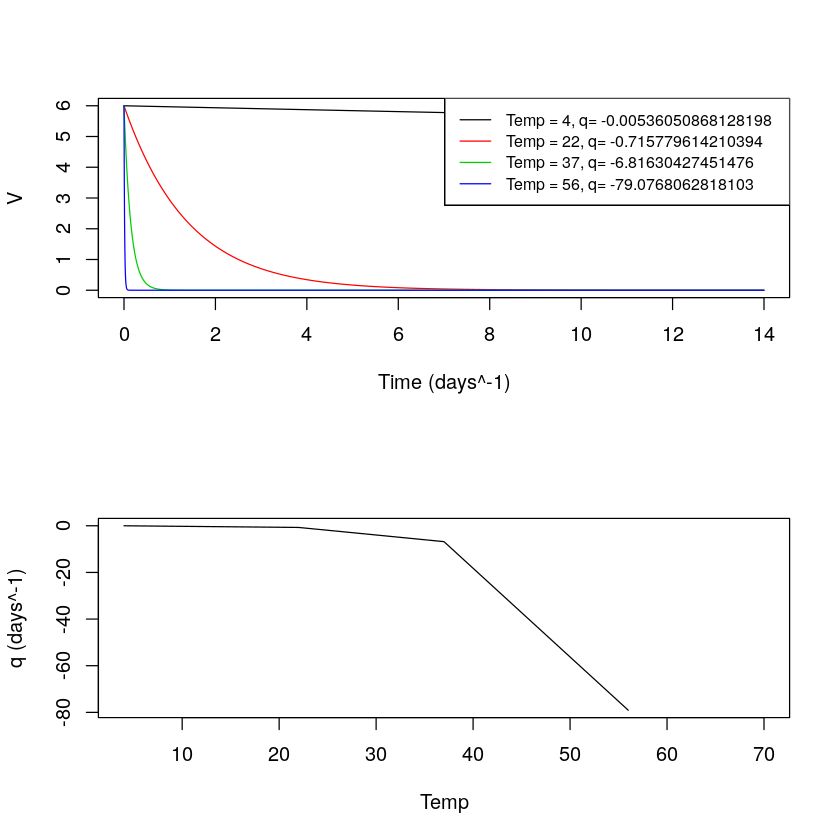

In [26]:
findq<-function(V_0,timepoint){
    x<-seq(0,10,length.out = 10000)
    q<-log(timepoint[2]/V_0)/timepoint[1]
    V<-V_0 * exp(q*x)
  #  plot(x,V,type="s")
    return(q)
    }

par(mfrow=c(2,1))
x<-c(4,22,37,56,70)
#until q undetectable for all
#y<-c(findq(6.51,c(14*24*60-30,6.04)),findq(6.51,c(7*3*60,3.48)),findq(6.57,c(1*3*60-30,3.23)),findq(6.65,c(10,3.84)),findq(5.34,c(5,0)))
y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))

t=seq(0,14,length.out = 100000)
V_0=6

#this is just an illustration
plot(1, type="n", xlab="Time (days^-1)", ylab="V", xlim=c(0, 14), ylim=c(0, 6))
for(i in 1:(length(y)-1)){
    V<-V_0 * exp(y[i]*t)
    lines(t,V,type="s",col=i)
   legend("topright", legend = c(paste0("Temp = ",x[1],", q= ", y[1]),paste0("Temp = ",x[2],", q= ", y[2]),paste0("Temp = ",x[3],", q= ", y[3]),paste0("Temp = ",x[4],", q= ", y[4])), col = c(1, 2,3,4),lty = 1,    cex = 0.8)

}

x<-c(4,22,37,56,70)
#until q undetectable for all
#y<-c(findq(6.51,c(14*24*60-30,6.04)),findq(6.51,c(7*3*60,3.48)),findq(6.57,c(1*3*60-30,3.23)),findq(6.65,c(10,3.84)),findq(5.34,c(5,0)))

y<-c(findq(6.51,c((14*24*60-30)/(24*60),6.04)),findq(6.51,c((7*3*60)/(24*60),3.48)),findq(6.57,c((1*3*60-30)/(24*60),3.23)),findq(6.65,c(10/(24*60),3.84)),findq(5.34,c(5/(24*60),0)))

plot(x,y,type="l",xlab="Temp",ylab="q (days^-1)")

q(T) is a quadratic equation fit to the growth rate at different temperatures using the vertex and one other point and temperature limits. As this results in negative numbers, it needs to be scaled to maintain the shape of the curve while removing negative values.

## H - containment

visual demonstration of how Hill function works 

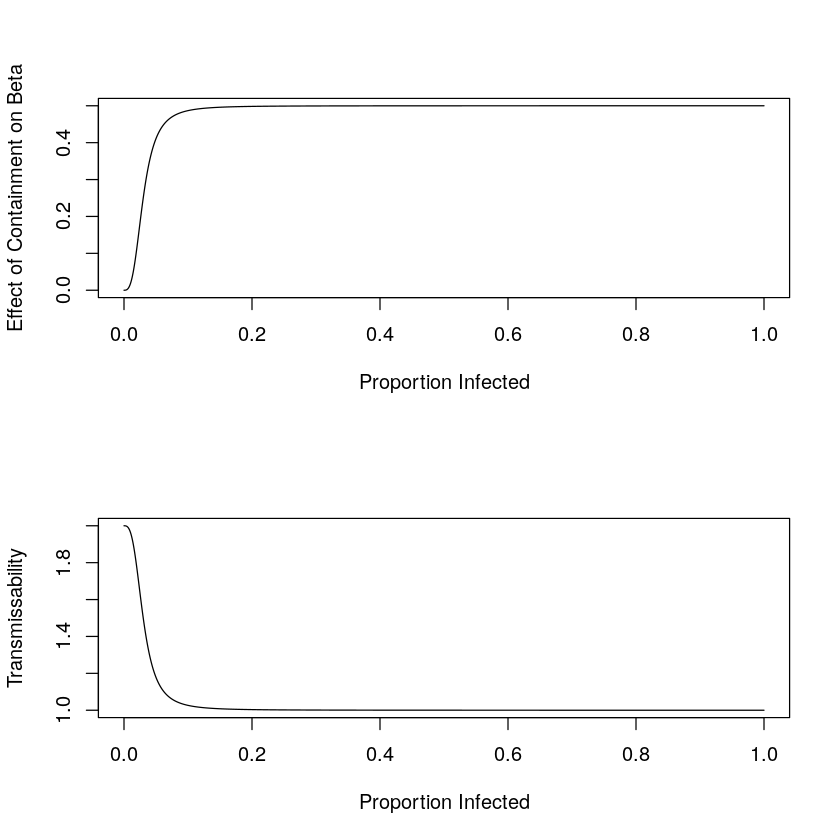

In [24]:

par(mfrow = c(2,1))

I<-seq(0,1,length.out = 10000)
d<-(0.5*I^3/(0.03^3+I^3))
plot(I,d,"s",ylab="Effect of Containment on Beta",xlab="Proportion Infected")
beta<-2*(1-0.5*(I^3/(0.03^3+I^3)))
plot(I,beta,"s",ylab="Transmissability",xlab="Proportion Infected")

## Plots

### Functions for R and S with T 

In [9]:
#R and S functions- for making quadratic and normal function
mortality_quadratic <- function(vertex , point , T_range, scaled_type) {
     
   #vertex is the maxima or minima, point is another point on the curve (usually min o)
   #scaled between 0 and 1 
   #finds a b and c
   #remember that applies only to T_range
   #find coefficients 
  
  
   a = ((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) 
   b = (((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * -2 * vertex[1]) 
   c = (((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * vertex[1] ^2 + vertex[2]) 
   if (scaled_type==1){
       T = seq(T_range[1], T_range[2] , length.out = 1000)
       M =  ((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * (T - vertex[1]) ^2 + vertex[2]
       c = c  - min(M) 
       }
   if (scaled_type==2){
       T = seq(T_range[1], T_range[2] , length.out = 1000)
       M =  ((point[2] - vertex[2]) / (point[1] - vertex[1]) ^ 2) * (T - vertex[1]) ^2 + vertex[2]
       a = a / (max(M) - min(M))
       b = b / (max(M) - min(M))
       c = (c  - min(M)) / (max(M) - min(M))
   } 
   #find scaled M and plot 
   #M = (M - min(M)) / (max(M) - min(M))
   #plot(T,M,type="s")
   return(c(a, b, c))
}

# if type of standard deviation (stype) ==1 then use upper to find s ,else use lower. 
#This is to solve the issue that if maximum occurs at upper confidence interval, s will be 0. 

duration_normal <- function(m , c, T_range, stype, scaled_type) {
    #parameters
    T = seq(T_range[1], T_range[2], length.out = 10000)
    c_u = c[2]
    c_l = c[1]
    m_T = m[1]
    m_d = m[2]
    #find s
    if (stype==1){
       s = (c_u - m_T) / 1.96
       }else{
          s = -(c_l - m_T) / 1.96
       }
  #find y acis of normal distribution given s   
   #N_D =  (1 / (sqrt(2 * pi) * s)) *  exp((-(T - m_T) ^ 2) / (2 * s ^ 2))
   #d = N_D * sqrt(2 * pi) * s
   scaling = 1
   if (scaled_type == 1 ){
     scaling = sqrt(2 * pi) * s
   }
   if (scaled_type == 2 ){
     scaling = sqrt(2 * pi) * s * m_d
   } 
   #plot(T,d)
   return(c(scaling, m_T, s))
}
#output_C<-duration_scaled_1(m = c(40,maxcont/24) , c=c(-10,40), T_range=c(-10,40))

#duration_scaled_1(m = c(40,maxcont/24) , c=c(-10,60), T_range=c(-10,40))


### Plotting S and C with T for different max temps

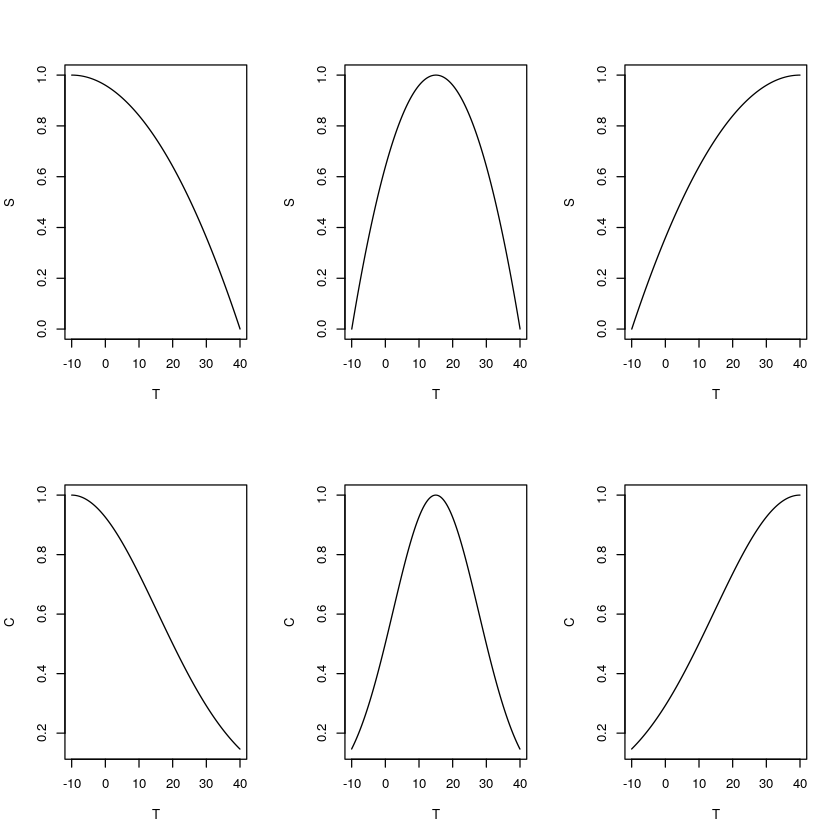

In [14]:

#setting parameters 
#here instead of in S/C functions because easier to change
#S
max_survival<- 0
min_survival<--40
scaling_S<-2 #scaled between 0 and 1 
#scaling_S<-1 # made positive but not scaled
#scaling_S<-0 # basic quadratic


#C
max_contact<-maxcont / 24
confidence_interval<-c(-10,40)
scaling_C<-1 #scaled between 0 and 1 
#scaling_C<-2 #scaled between 0 and maximum duration 
#scaling_C<-0 #not scaled



Survival <- function(T, vertex, T_range, point ) {
    # uses function to make mortality function to find the survival for a given value of T 
    # this is a seperate function to the mortality quadratic scaled function becase finds a specific T value from that function
    eq <- mortality_quadratic(vertex, point, T_range, scaled_type=scaling_S)  
    return(eq[1] * T ^ 2 + eq[2] * T + eq[3])
}
Contact <- function(T, m, c, T_range,stype) {
#   #finds equation given coordinates at maximum (m), upper and lower confidence interval (c), and range of T, and stype
   eq <- duration_normal(m, c, T_range,stype, scaled_type=scaling_C)#

    #uses equation to find contact duration at given T values 
   #need to work on c means, if c=T here then doesn't work because not enough density???- think this issue is solved with stype
   return(eq[1]*(1 / (sqrt(2 * pi) * eq[3]))*exp((-(T - eq[2]) ^ 2) / (2 * eq[3] ^ 2)))
}


#plotting  S(T) and C(T) when the maximum is different
par(mfrow = c(2, 3))


plottingS <- function(maxvec, range) {
  #plots for different maximum temperatures 
   T = seq(range[1], range[2] , length.out = 1000)
   for (i in maxvec) {
      temp_at_max <- i
      # the temp at min is the lower end of the range when the temp at max is closer to the upper end of the range and vice versa
      #this is because the quadratic is symmetric and bounded    
      if (i > (range[2] - range[1]) / 2) {
         temp_at_min <- range[1]
         }else{
            temp_at_min <- range[2]
         }
      #survival function finds equation given vertex, trange and point, then finds S for chosen T values  
      S= Survival(T = T, vertex = c(temp_at_max, max_survival),T_range = range, point = c(temp_at_min, min_survival))

      plot(T, S, type = "s")
   }
}

plottingS(maxvec = c(-10, 15, 40), range = c(-10, 40))

S <- function(temp_at_max, range, T) {
   #this function uses the temp at max and range to decide which end of range to allocate as minimum.
   #then finds the equation for the given range and temp at max and finds S for given T 
   #uses specific min and max y values. should probably move that to input
    
   # the temp at min is the lower end of the range when the temp at max is closer to the upper end of the range and vice versa
   #this is because the quadratic is symmetric and bounded     
   if (temp_at_max > (range[2] - range[1]) / 2) {
       temp_at_min <- range[1]
      }else{
        temp_at_min <- range[2]
      } 
    #outputs y value for temperature when vertexc, T_range and point are at values here
    return(Survival(T = T, vertex = c(temp_at_max, max_survival),T_range = range, point = c(temp_at_min, min_survival)))
}


plottingC <- function(maxvec, range) {
   #plots for different maximum temperatures
   T = seq(range[1], range[2] , length.out = 1000)
   for (i in maxvec) {
  #     #uses the value of maxvec to "decide" stype(decide whether lower or upper confidence interval is used to calculate standard deviation)
      if (abs(i-range[1])>abs(i-range[2])){
    #   #if the maximum temperature is closer to the upper end of the range than the lower, use the lower ci (so stype =0)
         stype=0
         }else{
            stype=1
         }
      #find C and plot given specific parameters
      C = Contact(T = T, m = c(i, max_contact), c = confidence_interval, T_range = range, stype=stype)
      plot(T, C, type = "S")
   }  
}
plottingC(maxvec = c(-10, 15, 40), range = c(-10, 40))

C <- function(temp_at_max, range, T) {
   #finds the equation fiven temp_at_max and range. then finds S for given T
   #uses where temp at max relates to range to determine stype (to determine whether lower or upper value of range is used to find SI)
   if (abs(temp_at_max-range[1])>abs(temp_at_max-range[2])){
      stype=0
      }else{
         stype=1
      }
   #finds C at T values for given parameters (contact finds equation using duration_normal_scaled)
   #t_range not strictly needed 
   return(Contact(T = T,m = c(temp_at_max, max_contact), c = confidence_interval, T_range = range, stype=stype))

   
}








### Plotting R0 

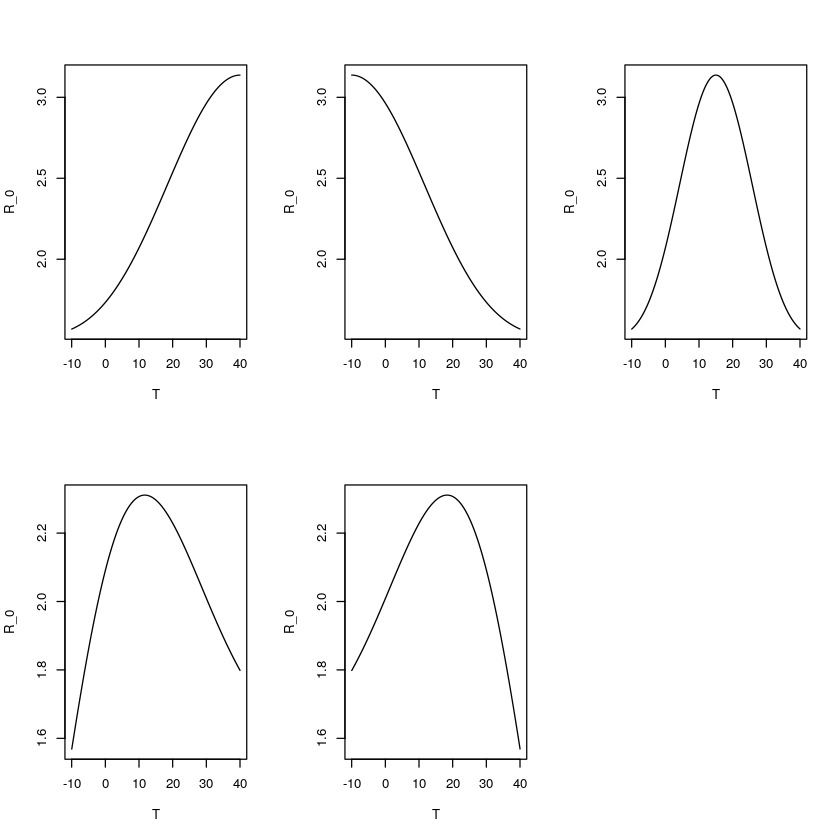

In [15]:
#plotting R0
par(mfrow = c(2, 3))
mu = 0
sigma = 0.25
alpha = 0.005
gamma = 0.25
beta_0 = 0.4

range = c(-10, 40)
T = seq(range[1], range[2] , length.out = 1000)
#completely susceptible population
#maxes is a matrix with different combinations of maximum for C and S 

maxes<-matrix(c(range[2],range[2],range[1],range[1],range[1] + ((range[2] - range[1]) / 2), 
                 range[1] + ((range[2] - range[1]) / 2),range[1],range[2],range[2],range[1]),byrow=T, nrow=5,ncol=2)
for (a in 1:nrow(maxes)){
    R_0 <-
      (sigma / (sigma + mu)) * 
      (beta_0 *(1 +  C(T = T, range = range, temp_at_max = maxes[a,1]) * S(T = T,range = range, temp_at_max = maxes[a,2])))/
      (mu + alpha + gamma)
    plot(T, R_0, type = "s")
}

#third and 5th parameters used fur simulations further down

#1 both peak at high temperature
#2 both peak at low temperature
#n3 both peak in midrange
#4 C peaks low, S peaks high
#5 C peaks high, S peaks low 

In [16]:
require("epimdr")

### Plotting time series with different levels of mismatch

It is worth noting that the parameter values have a huge impact - at some values no difference is visible  

$\beta_t = \beta_0  ( 1 + \beta_s \times C(T) \times S(T)) $


function for how temperature varies with time:
cos function, where max and min are the maximum and minimum temperatures respectively. 
this is for a 365 day cycle (but can be adapted by changing 365)  
$T=\frac{max-min}{2} \times \cos(\frac{2 \times pi}{365} \times time - \pi) + \frac{max+min}{2}$


In [22]:
Temp<- function(time,min,max) {
  # here, T is varying with time at a yearly cycle.
  return((max-min)/2 * cos((2 * pi / 365)* time - pi) + (max+min)/2)
}
#T<-seq(0,400,length.out = 1000)
#Y<-Temp(T,-10,40)
#plot(T,Y)

[1] "complete match (midrange)"
[1] "complete mismatch (C max temperature is high, S max temperature is low )"


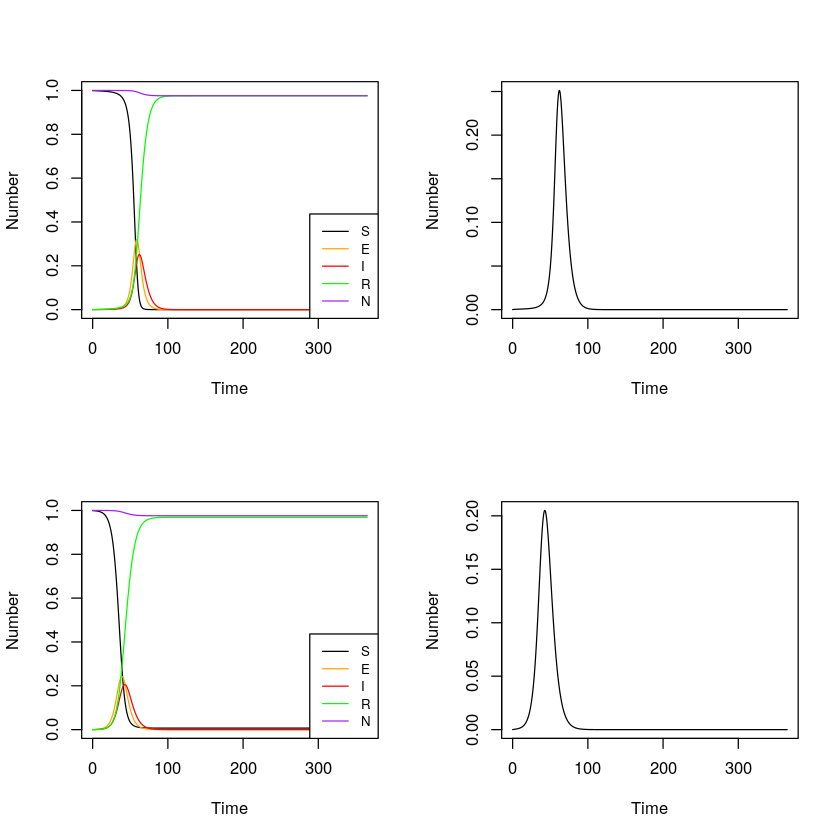

In [18]:
model <- function(time, values, parms) {
   #function where c changes with the climate and humidity at each timepoint
  
   #initial values
   S <- values[1]
   E <- values[2]
   I <- values[3]
   R <- values[4]
  
   #parameters
   mu <- parms[["mu"]]
   sigma <- parms[["sigma"]]
   alpha <- parms[["alpha"]]
   gamma <- parms[["gamma"]]
   beta0 <- parms[["beta0"]]
   beta_scaling <- parms[["beta_scaling"]]
   range <-parms[["range"]]
   nu <- parms[["nu"]]
   N <- parms[["N"]]
   mismatch <- parms[["mismatch"]]

   #find temperature given time
   T <- Temp(time=time,min=range[1],max=range[2])
   
   #find beta given temperature
   #2 options- mismatch=1 is when completely opposite maxima. =1, both peak at mid value
   if (mismatch==1){
      beta<-beta0 * (1 + beta_scaling* C(T = T, range = range, temp_at_max = range[2]) * 
                     S (T = T,range = range,temp_at_max = range[1]))        
      }else{
         midrange<-range[1] + ((range[2] - range[1]) / 2)
         beta<-beta0 * (1 + beta_scaling* C(T = T, range = range, temp_at_max = midrange) *
                        S (T = T,range = range,temp_at_max = midrange))     
      }

    
   #seir model
   dS = nu * N - beta * I * S / N - mu * S 
   dE = beta * S * I / N - (sigma + mu) * E
   dI = sigma * E - (alpha + mu + gamma) * I
   dR = gamma * I - mu * R 
    
  list(c(dS, dE, dI, dR))
}



plottime <- function(start, time, model, parms) {
   #plotting seir components over time
   out = ode(    y = start,    time = time,    func = model,    parms = parms  )
   Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
   out<-cbind( out, Nvec)
   plot(x = out[, "time"], y= out[, "S"], ylab = "Number", xlab = "Time",
        type = "l", xlim=c(min(time), max(time)),ylim=c(0, parms[["N"]]))
   lines(x = out[, "time"],y= out[, "E"], col = "orange")
   lines(x = out[, "time"],y= out[, "I"], col = "red")
   lines(x = out[, "time"],y= out[, "R"], col = "green")
   lines(x = out[, "time"],y= out[, "Nvec"], col = "purple")  
   legend( "bottomright",legend = c("S", "E", "I", "R","N"), 
          col = c("black", "orange", "red", "green","purple"), lty = 1, cex = 0.8)
    #plotting infection numbers over time
    plot(x = out[, "time"],   y= out[, "I"],    ylab = "Number",   xlab = "Time",    
       type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, max(out[,"I"]))) }

time = seq(0,365, by = 0.01)

par(mfrow = c(2, 2))

#2 simulations- only difference is mismatch
#these simulations are using graphs of  duration and mortality determined by earlier functions- Specifically S and R
parms1 = list( mu = 00.000,sigma = 0.2 ,alpha = 0.005, beta0 = 0.3,gamma =0.2,
               N = 1, nu = 0.0, range = c(-10,40), mismatch=0, beta_scaling=10)
print("complete match (midrange)")

start = c(S = 0.999*parms1[["N"]],
          E = 0.001*parms1[["N"]],
          I = 0.00*parms1[["N"]],
          R = 0*parms1[["N"]])
plottime(time = time,parms = parms1,start = start,  model = model)



parms2 = list( mu = 00.000, sigma = 0.2 , alpha = 0.005, beta0 = 0.3,  gamma =0.2,
              N = 1, nu = 0.0, range = c(-10,40), mismatch=1, beta_scaling=10)
print("complete mismatch (C max temperature is high, S max temperature is low )")
start = c(S = 0.999*parms2[["N"]],
          E = 0.001*parms2[["N"]],
          I = 0.00*parms2[["N"]],
          R = 0*parms2[["N"]])
plottime(time = time,parms = parms2,start = start,model = model)


### Adding Containment
$\beta_t = \beta_0  (1 + \beta_s \times S(T) \times C(T) (1 - containment \times \frac{I^3} {k^3 + I^3}))$
It seems likely that only contact duration would be modified by containment, so have done this differently to Neher 

[1] "no mismatch, with hill"
[1] "complete mismatch, with hill"


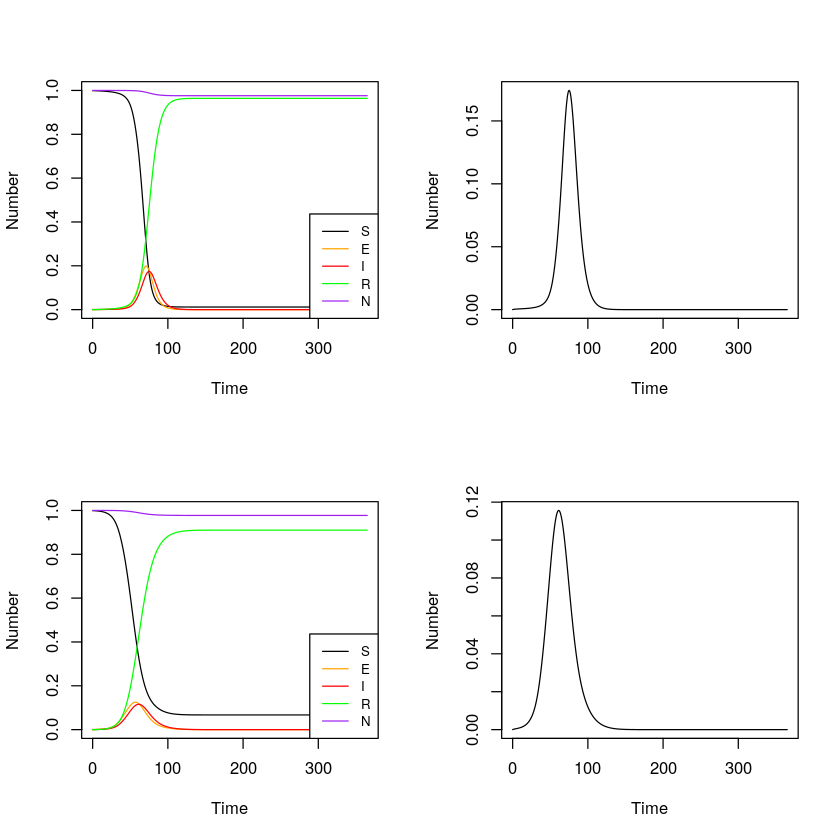

In [42]:
#here added containment by multiplying cs by hill not whole function
modelHill <- function(time, values, parms) {
   #function where c changes with the climate and humidity at each timepoint
  
   #initial values
   S <- values[1]
   E <- values[2]
   I <- values[3]
   R <- values[4]
  
    
   #parameters
   mu <- parms[["mu"]]
   sigma <- parms[["sigma"]]
   alpha <- parms[["alpha"]]
   gamma <- parms[["gamma"]]
   beta0 <- parms[["beta0"]]
   beta_scaling <- parms[["beta_scaling"]]
   range <-parms[["range"]]
   nu <- parms[["nu"]]
   N <- parms[["N"]]
   mismatch <- parms[["mismatch"]]
   containment <- parms[["containment"]]
   k <- parms[["k"]]
    
   #find temperature given time
   T <- Temp(time=time,min=range[1],max=range[2])
   
   #find beta given temperature
   #2 options- mismatch=1 is when completely opposite maxima. =1, both peak at mid value
   if (mismatch==1){
         midrange<-range[1] + ((range[2] - range[1]) / 2)
         beta<-beta0 * (1 + beta_scaling *  S (T = T,range = range,temp_at_max = range[1]) * 
                     C(T = T, range = range, temp_at_max = range[2])*(1 - containment * I^3 / (k^3 + I^3)))
       }else{
         midrange<-range[1] + ((range[2] - range[1]) / 2)
         beta<-beta0 * (1 + beta_scaling *  S (T = T,range = range,temp_at_max = midrange) * 
                     C(T = T, range = range, temp_at_max = midrange)*(1 - containment * I^3 / (k^3 + I^3)))
   }

    
   #seir model
   dS = nu * N - beta * I * S / N - mu * S 
   dE = beta * S * I / N - (sigma + mu) * E
   dI = sigma * E - (alpha + mu + gamma) * I
   dR = gamma * I - mu * R 
    
  list(c(dS, dE, dI, dR))
}

plottime <- function(start, time, model, parms) {
   #plotting seir components over time
   out = ode(    y = start,    time = time,    func = model,    parms = parms  )
   Nvec<-out[, "S"] + out[, "E"] + out[, "I"] + out[, "R"]
   out<-cbind( out, Nvec)
   plot(x = out[, "time"], y= out[, "S"], ylab = "Number", xlab = "Time",
        type = "l", xlim=c(min(time), max(time)),ylim=c(0, parms[["N"]]))
   lines(x = out[, "time"],y= out[, "E"], col = "orange")
   lines(x = out[, "time"],y= out[, "I"], col = "red")
   lines(x = out[, "time"],y= out[, "R"], col = "green")
   lines(x = out[, "time"],y= out[, "Nvec"], col = "purple")  
   legend( "bottomright",legend = c("S", "E", "I", "R","N"), 
          col = c("black", "orange", "red", "green","purple"), lty = 1, cex = 0.8)
    #plotting infection numbers over time
    plot(x = out[, "time"],   y= out[, "I"],    ylab = "Number",   xlab = "Time",    
       type = "l",   xlim=c(min(time), max(time)),  ylim=c(0, max(out[,"I"]))) }

time = seq(0,365, by = 0.01)

par(mfrow = c(2, 2))

#2 simulations- only difference is mismatch
#these simulations are using graphs of  duration and mortality determined by earlier functions- Specifically S and R
parms1 = list( mu = 00.000,sigma = 0.2 ,alpha = 0.005, beta0 = 0.3,gamma =0.2,
               N = 1, nu = 0.0, range = c(-10,40), mismatch=0, beta_scaling=5, 
              containment = 0.5 , k = 0.03)
print("complete match, with hill")

start = c(S = 0.999*parms1[["N"]],
          E = 0.001*parms1[["N"]],
          I = 0.00*parms1[["N"]],
          R = 0*parms1[["N"]])

plottime(time = time,parms = parms1,start = start,  model = modelHill)





parms2 = list( mu = 00.000, sigma = 0.2 , alpha = 0.005, beta0 = 0.3,  gamma =0.2,
              N = 1, nu = 0.0, range = c(-10,40), mismatch=1, beta_scaling=5,
              containment = 0.5 , k = 0.03)
print("complete mismatch, with hill")

start = c(S = 0.999*parms2[["N"]],
          E = 0.001*parms2[["N"]],
          I = 0.00*parms2[["N"]],
          R = 0*parms2[["N"]])

plottime(time = time,parms = parms2,start = start,model = modelHill)


generalise some functions,


include humidity-look into absolute humidity. claim from guinea pigs paper  
lag period?  
idea of model fitting to data using ABC- maybe for influenza  
currently worried about all the possible causes of seasonality that I'm not including! - immunity with climate, droplet size with humidity


for both S and C need to make a decision about scaling- (0-1 or more meaningful)
0-1 --> then will be dimensionless
meaningful -->units cancel but how do we make sure similar effect. (to scale this could / by max(C)* max(S)

## Parameter table

|Parameter|Meaning|Unit|Origin|
|------|------|------|------|
|$\alpha$     |rate of disease induced mortality (per capita?)   |unit time$^{-1}$  |Bjørnstad 2018|
|$\beta$     |transmission rate per infective    | unit time$^{-1}$   |Keeling and Rohani 2007|
|$\beta_0$     |average annual infection rate|unit time$^{-1}$      |Neher 2020|
|$\gamma$     |recovery rate - probably of recovery for an individual per unit time (reciprocal of infectious period)   |unit time$^{-1}$  |Keeling and Rohani 2007|
|$\mu$    |natural per capita death rate -not caused by disease|unit time$^{-1}$    |Keeling and Rohani 2007|
|$\nu$    |natural per capita birth rate |unit time$^{-1}$  |Keeling and Rohani 2007|
|$\sigma$     |rate of movement from E to I (reciprocal of latent period)|unit time$^{-1}$  Keeling and Rohani 2007|
|$S$     |number of susceptibles    |  n |Keeling and Rohani 2007|
|$E$     |number of exposed |  n   |Keeling and Rohani 2007|
|$I$     |number of infected     |  n |Keeling and Rohani 2007|
|$R$     |number of recovered    | n  |Keeling and Rohani 2007|
|$N$     |number of individauls   | n  |Keeling and Rohani 2007|
|$T$  |temperature |degrees c|-|
|$RH$   |relative humidity|%|-|
|$m$ |containment parameter|-|Neher 2020|
|$k$   |inflection point of Hill function||Neher 2020|
|$\epsilon$   |amplitude of seasonal forcing||Neher 2020|
|$\theta$  |time of peak transmissability||Neher 2020|
|$S$  |survival rate |$time^{-1}$|-|
|$C$  |Contact parameter|unit time|-|
|$H$  |dimensionless hill function- containment |-|Neher 2020|
|$d$  |average contact duration|unit time|-|
|$s$  |Standard distribution of normal distribution|-|-|
|$N_D$  |normal distribution|-|-|
|$m_T$,$m_d$ |Temperature and duration at maximum duration |degrees C, unit time|-|
|$c_l$,$c_u$|lower, upper interval at which 95\%  of the duration is likely to occur |-|-|
|$q$   |viral rate of decay|$time^{-1}$||
|$V$   |viral titre/amount |not sure yet (but cancels)||
|$V_0$   |initial viral titre/amount |not sure yet (but cancels)||
|$f(T)$   |quadratic function for S |time$^-1$||



kappa not used in these models but :|$\kappa$   |average number of contacts per individual per unit time|$year^-1$ |Keeling and Rohani 2007||$m_T$,$m_d$ |Temperature and duration at midpoint duration |degrees C, unit time|-|
|$p_T$,$p_d$  |Temperature and duration at a point|degrees C, unit time|-|

units calculated from:  
units of de/dt,ds/st,di/dt, dr/dt$N\times$unit time$^{-1}$ 
